# Aviakompaniya yo'lovchilarining qoniqishi 

## Faoliyatni o\`rganish 

**Loyiha maqsadi**: Amerika Qo'shma Shtatlaridagi parvozlarga nisbatan yo'lovchilarning fikri haqida berilgan ma'lumotlarga asosan yo'lovchilarning qoniqishlarini bashorat qiladigan model yaratish.

In [1]:
# !pip install opendatasets
# !pip install matplotlib_inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Ma\`lumotlar bilan tanishish 

In [4]:
# od.download('https://www.kaggle.com/competitions/aviakompaniya/data')

In [5]:
os.listdir('./aviakompaniya')

['sample_submission.csv', 'test_dataset.csv', 'train_dataset.csv']

In [6]:
df = pd.read_csv('./aviakompaniya/train_dataset.csv')
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,...,4,3,1,3,4,3,4,10,3.0,0
1,2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,...,5,5,5,5,3,5,3,0,0.0,1
2,3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,...,4,5,2,5,3,5,4,0,10.0,0


Yo\`lovchi ma\`lumotlariga aloqador bo\`lmagan `id` ustunini olib tashlaymiz 

In [7]:
class DropUnnecessaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features=['id']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                X.drop(f, axis=1, inplace=True)
        return X
drop_features = DropUnnecessaryFeatures()
drop_features.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,4,3,1,3,4,3,4,10,3.0,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,5,5,5,3,5,3,0,0.0,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,4,5,2,5,3,5,4,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,4,4,1,4,4,4,3,21,12.0,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,4,4,4,4,1,4,4,34,21.0,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,4,4,4,3,4,3,37,38.0,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,3,4,5,5,5,4,5,64,210.0,1


### Ustunlar tavsifi
* `Gender`: yo'lovchilarning jinsi (ayol, erkak)
* `Customer Type`: mijoz turi (sodiq mijoz, ishonchsiz mijoz)
* `Age`: yo'lovchilarning haqiqiy yoshi
* `Type of Travel`: yo'lovchilar parvozining maqsadi (shaxsiy sayohat, biznes sayohat)
* `Class`: yo'lovchilar samolyotida sayohat klassi (Business, Eco, Eco Plus)
* `Flight distance`: Ushbu sayohatning parvoz masofasi
* `Inflight wifi service`: Parvoz ichidagi Wi-Fi xizmatidan qoniqish darajasi (0: Tegishli emas; 1-5)
* `Departure/Arrival time convenient`: Ketish/Kelish vaqtining qoniqish darajasi
* `Ease of Online booking`: Onlayn bron qilishdan qoniqish darajasi
* `Gate location`: Darvoza joylashuvidan qoniqish darajasi
* `Food and drink`: Oziq-ovqat va ichimlikdan qoniqish darajasi
* `Online boarding`: Onlayn bortdan qoniqish darajasi
* `Seat comfort`: O'rindiqning qulayligidan qoniqish darajasi
* `Inflight entertainment`: Parvoz ichidagi o'yin-kulgidan qoniqish darajasi
* `On-board service`: Bort xizmatidan qoniqish darajasi
* `Leg room service`: oyoq xonasi xizmatidan qoniqish darajasi
* `Baggage handling`: bagajni tashishdan qoniqish darajasi
* `Check-in service`: Ro'yxatdan o'tish xizmatidan qoniqish darajasi
* `Inflight service`: Parvoz ichidagi xizmatdan qoniqish darajasi
* `Cleanliness`: Tozalikdan qoniqish darajasi
* `Departure Delay in Minutes`: jo‘nash vaqtida kechikish daqiqalari
* `Arrival Delay in Minutes`: yetib kelganda kechikish daqiqalari
* `Satisfaction`: Aviakompaniyaning qoniqish darajasi (qoniqish, neytral yoki norozilik)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             10000 non-null  object 
 1   Customer Type                      10000 non-null  object 
 2   Age                                10000 non-null  int64  
 3   Type of Travel                     10000 non-null  object 
 4   Class                              10000 non-null  object 
 5   Flight Distance                    10000 non-null  int64  
 6   Inflight wifi service              10000 non-null  int64  
 7   Departure/Arrival time convenient  10000 non-null  int64  
 8   Ease of Online booking             10000 non-null  int64  
 9   Gate location                      10000 non-null  int64  
 10  Food and drink                     10000 non-null  int64  
 11  Online boarding                    10000 non-null  int6

In [9]:
df['Arrival Delay in Minutes'].describe()

count    9972.000000
mean       14.709888
std        40.046355
min         0.000000
25%         0.000000
50%         0.000000
75%        12.000000
max       924.000000
Name: Arrival Delay in Minutes, dtype: float64

`Arrival Delay in Minutes` ustunida 28 ta **Nan** qiymatlar bor ekan. Ularni 0 qiymat bilan to\`ldiramiz.

In [10]:
class FillMissingValues(BaseEstimator, TransformerMixin):
    def __init__(self, value=0):
        self.value = value
    def fit(self, X):
        return self
    def transform(self, X):
        X.fillna(self.value, inplace=True)
        return X
fill_missing = FillMissingValues()
fill_missing.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,4,3,1,3,4,3,4,10,3.0,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,5,5,5,3,5,3,0,0.0,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,4,5,2,5,3,5,4,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,4,4,1,4,4,4,3,21,12.0,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,4,4,4,4,1,4,4,34,21.0,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,4,4,4,3,4,3,37,38.0,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,3,4,5,5,5,4,5,64,210.0,1


Kategoriyali va baholi ya\`ni qoniqish darajasini ifodalovchi ustunlarni aniqlaymiz

In [11]:
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
rat_cols = ['Inflight wifi service', 'Departure/Arrival time convenient',
            'Ease of Online booking', 'Gate location', 'Food and drink',
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 
           'On-board service', 'Leg room service', 'Baggage handling', 
           'Checkin service', 'Inflight service', 'Cleanliness']

## Ma\`lumotlarni tahlil qilish 

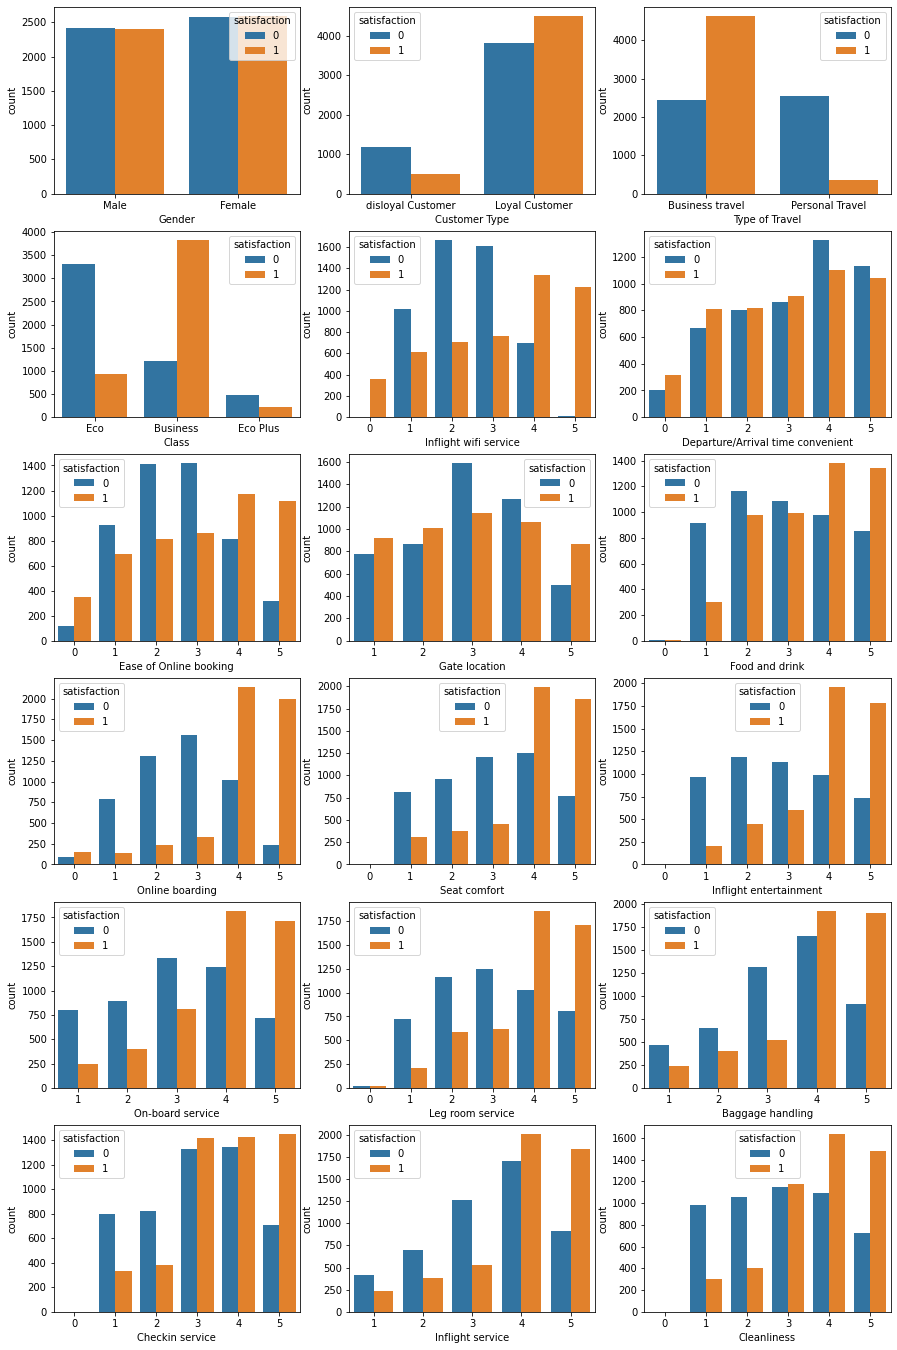

In [12]:
inds = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2),(2,0),(2,1),(2,2),
        (3,0),(3,1),(3,2),(4,0),(4,1),(4,2),(5,0),(5,1),(5,2)]
fig, ax = plt.subplots(6, 3, figsize=(15, 24))
for col, ind in zip(cat_cols + rat_cols, inds):
    sns.countplot(ax=ax[ind], data=df, x=col, hue='satisfaction')

Ayrim hizmatlar uchun 0 baho belgilagan mijozlarning aksariyati parvozdan qanoatlangan. Shuning uchun ham 0 qiymatlarni 5 bilan almashtiramiz.

In [13]:
class ValueChanger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        rat_cols = ['Inflight wifi service', 'Departure/Arrival time convenient',
            'Ease of Online booking', 'Gate location', 'Food and drink',
            'Online boarding', 'Seat comfort', 'Inflight entertainment', 
           'On-board service', 'Leg room service', 'Baggage handling', 
           'Checkin service', 'Inflight service', 'Cleanliness']
        X[rat_cols] = X[rat_cols].replace(0, 5)
        return X
value_changer = ValueChanger()
value_changer.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,4,3,1,3,4,3,4,10,3.0,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,5,5,5,3,5,3,0,0.0,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,1,1,1,1,1,1,2,0,18.0,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,4,5,2,5,3,5,4,0,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,4,4,1,4,4,4,3,21,12.0,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,4,4,4,4,1,4,4,34,21.0,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,4,4,4,3,4,3,37,38.0,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,3,4,5,5,5,4,5,64,210.0,1


In [14]:
num_cols = ['Departure Delay in Minutes', 'Age', 'Flight Distance', 
            'Arrival Delay in Minutes']
df[num_cols].describe()

,Departure Delay in Minutes,Age,Flight Distance,Arrival Delay in Minutes
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,14.429900,39.375100,1229.556200,14.668700
std,39.659674,14.897959,1022.281958,39.997799
min,0.000000,7.000000,31.000000,0.000000
25%,0.000000,27.000000,421.000000,0.000000
50%,0.000000,40.000000,863.500000,0.000000
75%,12.000000,51.000000,1806.750000,12.000000
max,921.000000,80.000000,4983.000000,924.000000


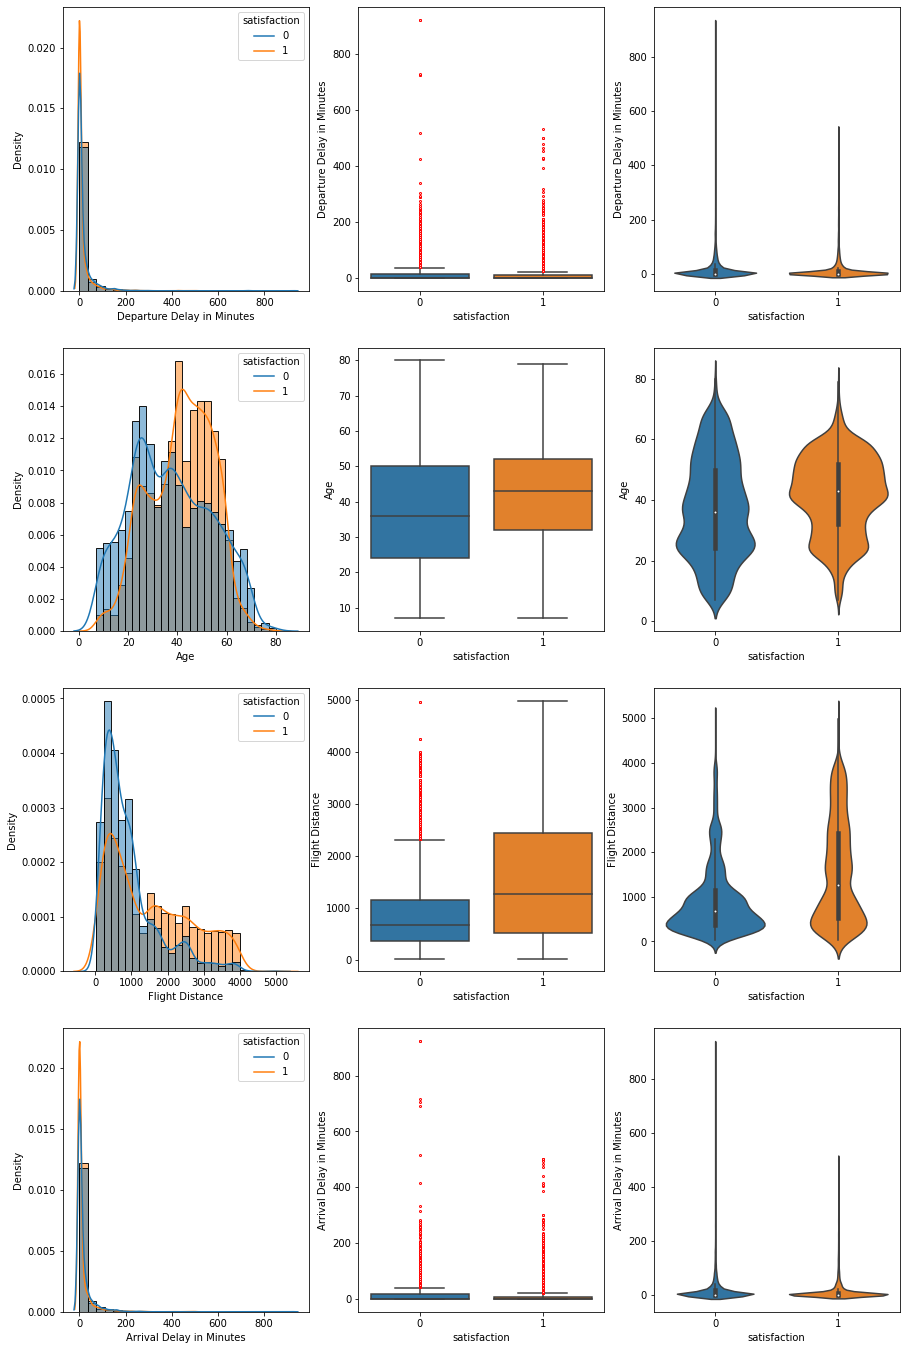

In [15]:
flierprops = dict(marker='o', markerfacecolor='w', markersize=2,
linestyle='none', markeredgecolor='r')

inds = [[(0,0),(0,1),(0,2)],[(1,0),(1,1),(1,2)],[(2,0),(2,1),(2,2)],
       [(3,0),(3,1),(3,2)]]
fig, ax = plt.subplots(4, 3, figsize=(15, 24))
for col, ind in zip(num_cols, inds):
    sns.histplot(ax=ax[ind[0]],data=df, x=col, hue='satisfaction', bins=25, stat='density')
    sns.kdeplot(ax=ax[ind[0]], data=df, x=col, hue='satisfaction', c='r')
    sns.boxplot(ax=ax[ind[1]], data=df, y=col, x='satisfaction', fliersize=2, flierprops = flierprops)
    sns.violinplot(ax=ax[ind[2]], data=df, y=col, x='satisfaction')

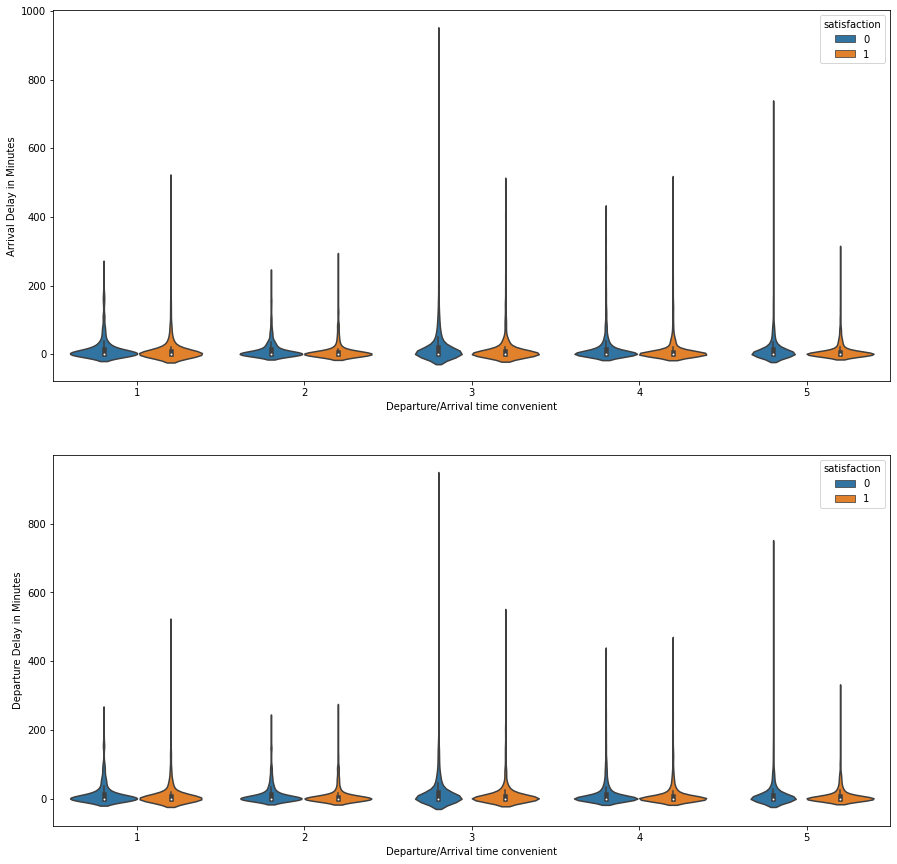

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))
sns.violinplot(ax=ax[0], data=df, y='Arrival Delay in Minutes', x='Departure/Arrival time convenient', hue='satisfaction')
sns.violinplot(ax=ax[1], data=df, y='Departure Delay in Minutes', x='Departure/Arrival time convenient', hue='satisfaction')
plt.show()

Yetib kelgandagi va jo\`nab ketishdagi kechikish vaqtlari yo\`lovchining ushbu ko\`rsatkichlardan qoniqish darajasiga mutanosib emas ekan. Shuningdek parvozdan qanoatlangan va qanoatlanmagan mijozlar uchun kechikish vaqtlari deyarli bir xil. Demak ushbu ko\`rsatkichlarni olib tashlasak bo\`ladi.

In [17]:
class DropUnnecessaryFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features=['id', 'Departure Delay in Minutes',
                                 'Arrival Delay in Minutes']):
        self.features = features
    def fit(self, X):
        return self
    def transform(self, X):
        if self.features:
            for f in self.features:
                X.drop(f, axis=1, inplace=True)
        return X
dropper = DropUnnecessaryFeatures(['Departure Delay in Minutes',
                                 'Arrival Delay in Minutes'])
dropper.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,2,4,4,3,1,3,4,3,4,0
1,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,4,5,5,5,5,3,5,3,1
2,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,4,3,1,1,1,1,1,1,2,0
3,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,2,2,4,4,5,5,4,2,1
4,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,3,4,4,5,2,5,3,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Female,Loyal Customer,54,Personal Travel,Eco,1068,1,4,1,2,...,5,4,4,4,1,4,4,4,3,0
9996,Female,Loyal Customer,54,Business travel,Eco Plus,1399,4,1,1,1,...,3,3,4,4,4,4,1,4,4,0
9997,Male,Loyal Customer,46,Business travel,Business,1440,3,3,2,3,...,4,5,4,4,4,4,3,4,3,1
9998,Female,Loyal Customer,41,Business travel,Business,90,4,1,4,4,...,4,5,3,4,5,5,5,4,5,1


## Ma\`lumotlarni mashinali o\`rgatish algoritmlari uchun tayyorlash

**Kategoriyali ustunlarni sonli turga o\`tkazamiz**

In [18]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        features = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
        gender_dict = {'Female': 0, 'Male': 1}
        customer_type_dict = {'disloyal Customer': 0, 'Loyal Customer': 1}
        type_of_travel_dict = {'Personal Travel': 0, 'Business travel': 1}
        class_dict = {'Eco': 0, 'Eco Plus': 1, 'Business': 2}
        encoding_map = {'Gender': gender_dict, 'Customer Type': customer_type_dict, 
                       'Type of Travel': type_of_travel_dict, 'Class': class_dict}
        for f in features:
            X[f] = X[f].map(encoding_map[f])
        return X
encoder = Encoder()
encoder.fit_transform(df)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,satisfaction
0,1,0,33,1,0,571,2,3,2,4,...,2,4,4,3,1,3,4,3,4,0
1,0,1,49,1,2,1431,4,1,4,4,...,5,4,5,5,5,5,3,5,3,1
2,0,1,43,1,0,867,1,4,4,4,...,4,3,1,1,1,1,1,1,2,0
3,0,1,27,1,2,1550,3,3,3,3,...,2,2,2,4,4,5,5,4,2,1
4,1,1,11,0,0,526,3,4,3,2,...,3,4,4,5,2,5,3,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,54,0,0,1068,1,4,1,2,...,5,4,4,4,1,4,4,4,3,0
9996,0,1,54,1,1,1399,4,1,1,1,...,3,3,4,4,4,4,1,4,4,0
9997,1,1,46,1,2,1440,3,3,2,3,...,4,5,4,4,4,4,3,4,3,1
9998,0,1,41,1,2,90,4,1,4,4,...,4,5,3,4,5,5,5,4,5,1


**Barcha qiymatlarni bir oraliqqa akslantirib olamiz**

In [19]:
X = df.drop('satisfaction', axis=1).copy(deep=True)
means = X.mean()
stds = X.std()
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, df):
        return self
    def transform(self, df):
        cols = df.columns
        if cols.isin(['satisfaction']).any():
            X = df.drop('satisfaction', axis=1).copy(deep=True)
        else: X=df.copy(deep=True)
        X = (X - means) / stds
        if cols.isin(['satisfaction']).any():
            X['satisfaction'] = df['satisfaction']
        df = X.copy(deep=True)
        return df
scaler = Scaler()
df = scaler.fit_transform(df)

In [20]:
pipeline = Pipeline([
    ('attributeDropper', DropUnnecessaryFeatures()),
    ('fillMissing', FillMissingValues()),
    ('valueChanger', ValueChanger()),
    ('encoder', Encoder()),
    ('scaler', Scaler())
])

In [21]:
X = df.drop('satisfaction', axis=1).copy(deep=True)
y = df['satisfaction']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

## Modellash

In [22]:
def cl_report(y_true, y_pred):
    print('Roc_auc: ', roc_auc_score(y_true, y_pred))
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Precision: ', precision_score(y_true, y_pred))
    print('Recall: ', recall_score(y_true, y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

### LogisticRegression

Roc_auc:  0.8722558485852907
Accuracy:  0.873
Precision:  0.8603351955307262
Recall:  0.8988326848249028


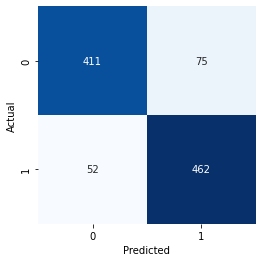

In [23]:
logistic_cl = LogisticRegression()
logistic_cl.fit(X_train, y_train)
y_pred_lr = logistic_cl.predict(X_valid)
cl_report(y_valid, y_pred_lr)

### SupportVectorClasification

Roc_auc:  0.9335358921394372
Accuracy:  0.933
Precision:  0.9533468559837728
Recall:  0.914396887159533


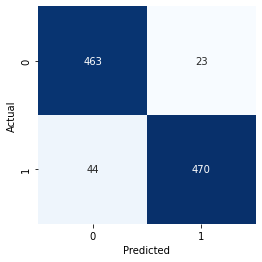

In [24]:
sv_cl = SVC()
sv_cl.fit(X_train, y_train)
y_pred_sv = sv_cl.predict(X_valid)
cl_report(y_valid, y_pred_sv)

### DecisionTreeClassifier

Roc_auc:  0.9265023778642455
Accuracy:  0.926
Precision:  0.9453441295546559
Recall:  0.9085603112840467


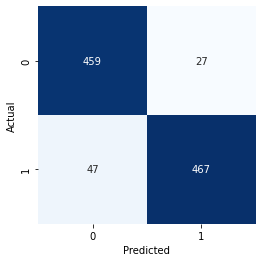

In [25]:
tree_cl = DecisionTreeClassifier()
tree_cl.fit(X_train, y_train)
y_pred_dt = tree_cl.predict(X_valid)
cl_report(y_valid, y_pred_dt)

### RandomForestClassifier

Roc_auc:  0.945489263582649
Accuracy:  0.945
Precision:  0.9636363636363636
Recall:  0.9280155642023347


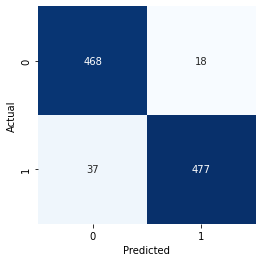

In [26]:
forest_cl = RandomForestClassifier(n_estimators=980)
forest_cl.fit(X_train, y_train)
y_pred_rf = forest_cl.predict(X_valid)
cl_report(y_valid, y_pred_rf)

## Sinov to\`plami uchun xulosa qilish

In [27]:
test_df = pd.read_csv('./aviakompaniya/test_dataset.csv')

In [28]:
test_df = pipeline.fit_transform(test_df)
test_df

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
0,-0.966704,0.451424,-0.964904,-1.556677,-1.123445,1.442306,-0.729906,-0.946023,-0.764135,0.014806,-0.917680,-0.372025,1.150482,-1.054013,0.428232,0.435114,-0.568357,1.302658,-2.280707,1.287886
1,-0.966704,0.451424,0.646055,0.642330,0.957586,0.384868,-1.491257,-1.658874,-1.504360,-1.543702,-0.165792,0.416832,0.387614,-1.054013,-1.140670,-1.111133,-1.408872,0.507821,-1.429729,-0.238136
2,1.034339,0.451424,0.780301,0.642330,0.957586,-0.872124,0.792794,0.479677,0.716316,0.794060,-0.917680,1.205689,1.150482,1.199114,1.212683,1.208238,1.112675,0.507821,1.123206,0.524875
3,1.034339,0.451424,-0.360794,0.642330,-0.082929,-1.109827,1.554144,1.192527,1.456541,0.014806,1.337986,1.205689,-1.900992,1.199114,0.428232,0.435114,-2.249388,-0.287016,-0.578750,1.287886
4,1.034339,0.451424,-0.360794,-1.556677,-1.123445,-0.613878,0.792794,0.479677,0.716316,0.014806,0.586097,1.205689,1.150482,1.199114,0.428232,1.208238,0.272159,1.302658,1.123206,1.287886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.034339,0.451424,-0.897781,0.642330,0.957586,1.681966,0.031444,-0.233173,0.716316,0.014806,0.586097,0.416832,0.387614,0.448072,-1.925121,0.435114,-1.408872,-0.287016,-2.280707,0.524875
3996,-0.966704,0.451424,-1.099151,-1.556677,-1.123445,-0.940598,-1.491257,-0.233173,1.456541,0.014806,-0.917680,1.205689,-1.138124,-1.054013,-0.356219,-1.111133,0.272159,-1.081853,-0.578750,-1.001147
3997,1.034339,0.451424,-0.092301,0.642330,-1.123445,-0.613878,-0.729906,-1.658874,-1.504360,-1.543702,-0.917680,-1.160882,-1.138124,-1.054013,-1.925121,-1.884257,-1.408872,-1.081853,-0.578750,-1.001147
3998,1.034339,0.451424,-1.099151,0.642330,-1.123445,-0.246073,1.554144,-0.946023,-0.764135,-0.764448,1.337986,0.416832,0.387614,1.199114,-1.925121,1.208238,-2.249388,-1.876690,-0.578750,1.287886


In [29]:
y_pred = forest_cl.predict(test_df)

In [30]:
submission_sol = pd.DataFrame({'id': range(1, len(test_df)+1), 'satisfaction': y_pred})

In [31]:
submission_sol

,id,satisfaction
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
3995,3996,1
3996,3997,0
3997,3998,0
3998,3999,1


In [32]:
submission_sol.to_csv('satisfaction_submission.csv', index=False)